# NVIDIA (NVDA) — Automated Financial Analysis Notebook

**Purpose:** Fetch market/data, compute valuation metrics (market cap, P/S, P/E, EV/Revenue where possible), collect analyst consensus, institutional and insider activity, produce charts and export CSVs. Designed to be run end-to-end and scheduled later.

**How to use:** Run cells top-to-bottom. Requires internet. Notebook uses `yfinance`, `pandas`, `requests`, and `matplotlib`. Install missing packages with pip.

---

**Quick checklist (one-day plan):**
1. Run the notebook to fetch live data.
2. Inspect key metrics: market cap, price-to-sales, growth rates.
3. Pull analyst consensus & price targets.
4. Pull institutional 13F/inflow/outflow summary and recent 13D/13G activity.
5. Pull insider trades (Form 4) for evidence of insider buying/selling.
6. Visualize revenue/earnings growth, margins, and valuation history.
7. Produce a recommendation (Buy/Hold/Sell) template based on quant rules + qualitative checks.


In [ ]:
# If packages missing, uncomment and run the following (local environment only)
# !pip install yfinance pandas matplotlib requests lxml beautifulsoup4 yahooquery


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = (10,6)

TICKER = 'NVDA'

# helper: pretty display
from IPython.display import display, Markdown

def show(title, df=None):
    display(Markdown('### ' + title))
    if df is not None:
        display(df)

# helper: safe call
def safe_get(url, headers=None):
    try:
        return requests.get(url, headers=headers, timeout=15)
    except Exception as e:
        print('Request failed:', e)
        return None

print('Helpers loaded. Ticker =', TICKER)


Helpers loaded. Ticker = NVDA


In [4]:
# Fetch with yfinance
ticker = yf.Ticker(TICKER)
info = ticker.info

# key metrics
market_cap = info.get('marketCap')
previous_close = info.get('previousClose')
price = info.get('currentPrice') or previous_close
shares_outstanding = market_cap / price if market_cap and price else None

def human(x):
    if x is None: return None
    for unit in ['','K','M','B','T']:
        if abs(x) < 1000.0:
            return f"{x:,.2f}{unit}"
        x /= 1000.0
    return f"{x:,.2f}P"

metrics = {
    'price': price,
    'market_cap': market_cap,
    'shares_outstanding_est': shares_outstanding,
    'trailingPE': info.get('trailingPE'),
    'forwardPE': info.get('forwardPE'),
    'priceToSalesTrailing12Months': info.get('priceToSalesTrailing12Months'),
    'enterpriseValue': info.get('enterpriseValue'),
}

show('Realtime summary (via yfinance)', pd.Series(metrics))
print('\nNOTE: yfinance info results depend on the package version and may be rate-limited or change over time.')


### Realtime summary (via yfinance)

price                           1.826400e+02
market_cap                      4.460857e+12
shares_outstanding_est          2.442432e+10
trailingPE                      5.203419e+01
forwardPE                       4.433010e+01
priceToSalesTrailing12Months    2.699983e+01
enterpriseValue                 4.391959e+12
dtype: float64


NOTE: yfinance info results depend on the package version and may be rate-limited or change over time.


In [5]:
# Historical income statement and revenue growth (using yfinance financials)
try:
    financials = ticker.financials.transpose()
    income = financials
    rev = income['Total Revenue'] if 'Total Revenue' in income.columns else income.get('Revenue')
    show('Recent income statement (transpose)', income.head())
except Exception as e:
    print('Could not fetch financials via yfinance:', e)

# Use yahooquery as fallback for standardized fields (user can install)


### Recent income statement (transpose)

,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,EBIT,...,Interest Expense Non Operating,Interest Income Non Operating,Operating Income,Operating Expense,Research And Development,Selling General And Administration,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue
2025-01-31,0.0,0.133,8.613700e+10,0.000000e+00,0.000000e+00,7.288000e+10,1.864000e+09,3.263900e+10,8.613700e+10,8.427300e+10,...,247000000.0,1.786000e+09,8.145300e+10,1.640500e+10,1.291400e+10,3.491000e+09,9.785800e+10,3.263900e+10,1.304970e+11,1.304970e+11
2024-01-31,0.0,0.120,3.558300e+10,0.000000e+00,0.000000e+00,2.976000e+10,1.508000e+09,1.662100e+10,3.558300e+10,3.407500e+10,...,257000000.0,8.660000e+08,3.297200e+10,1.132900e+10,8.675000e+09,2.654000e+09,4.430100e+10,1.662100e+10,6.092200e+10,6.092200e+10
2023-01-31,-284130000.0,0.210,7.339000e+09,-1.353000e+09,-1.353000e+09,4.368000e+09,1.543000e+09,1.161800e+10,5.986000e+09,4.443000e+09,...,262000000.0,2.670000e+08,5.577000e+09,9.779000e+09,7.339000e+09,2.440000e+09,1.535600e+10,1.161800e+10,2.697400e+10,2.697400e+10
2022-01-31,0.0,0.019,1.135100e+10,0.000000e+00,0.000000e+00,9.752000e+09,1.174000e+09,9.439000e+09,1.135100e+10,1.017700e+10,...,236000000.0,2.900000e+07,1.004100e+10,7.434000e+09,5.268000e+09,2.166000e+09,1.747500e+10,9.439000e+09,2.691400e+10,2.691400e+10


In [6]:
# Analyst consensus: Scrape Yahoo Finance "analysis" tab

def get_yahoo_analysis(ticker_sym):
    url = f'https://finance.yahoo.com/quote/{ticker_sym}/analysis?p={ticker_sym}'
    r = safe_get(url, headers={'User-Agent':'Mozilla/5.0'})
    if not r:
        return None
    soup = BeautifulSoup(r.text, 'lxml')
    tables = soup.find_all('table')
    rows = []
    for t in tables:
        for tr in t.find_all('tr'):
            cols = [c.get_text(strip=True) for c in tr.find_all(['th','td'])]
            rows.append(cols)
    return rows

rows = get_yahoo_analysis(TICKER)
if rows:
    print('Sample rows from Yahoo Finance analysis page:')
    for r in rows[:10]:
        print(r)
else:
    print('Could not parse Yahoo analysis page. Consider using MarketBeat/StreetInsider/Refinitiv API if you have access.')


Could not parse Yahoo analysis page. Consider using MarketBeat/StreetInsider/Refinitiv API if you have access.


In [7]:
# Institutional ownership summary (MarketBeat example)
def get_marketbeat_institutional(ticker_sym):
    url = f'https://www.marketbeat.com/stocks/NASDAQ/{ticker_sym}/institutional-ownership/'
    r = safe_get(url, headers={'User-Agent':'Mozilla/5.0'})
    if not r:
        return None
    soup = BeautifulSoup(r.text, 'lxml')
    text = soup.get_text(separator='|')
    return text[:2000]

mb = get_marketbeat_institutional(TICKER)
if mb:
    print('MarketBeat institutional page text (truncated):')
    print(mb[:1000])
else:
    print('MarketBeat fetch failed; consider APIs like SEC EDGAR/13F or paid data sources for robust automation.')


MarketBeat institutional page text (truncated):

|
|
|
	NVIDIA (NVDA) Institutional Ownership 2025
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|Skip to main content|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|
|Research Tools|
|
|All Access Research Tools|
|
|Live News Feed |
|Momentum Alerts |
|Idea Engine |
|Export Data (CSV) |
|See All Research Tools|
|
|
|My MarketBeat|
|
|My Portfolio|
|My Newsletter|
|My Account|
|
|
|
|Calculators|
|
|Dividend Calculator|
|Dividend Yield Calculator|
|Market Cap Calculator|
|Options Profit Calculator|
|Stock Average Calculator|
|Stock Split Calculator|
|Stock Profit Calculator|
|
|
|
|Stock Screeners|
|
|Stock Screener|
|ETF Screener |
|
|
|Trending Stocks|
|
|Trending MarketBeat Stocks |
|Trending Media Mentions |
|High Media Sentiment Stocks |
|
|
|Premium Reports|
|
|7 Energy Stocks to Buy and Hold Forever |Elon Musk's Next Move |10 Stocks Set to Soar in Fall 2025 |7 A

In [8]:
# Simple SEC form4 fetch via secform4.com (or EDGAR API for robust)
insider_url = 'https://www.secform4.com/insider-trading/1045810.htm'  # example site
r = safe_get(insider_url, headers={'User-Agent':'Mozilla/5.0'})
if r:
    soup = BeautifulSoup(r.text, 'lxml')
    table = soup.find('table')
    if table:
        df = pd.read_html(str(table))[0]
        show('Recent insider trades (sample from secform4.com)', df.head())
    else:
        print('No table found on example insider page; use SEC EDGAR API for production.')
else:
    print('Could not retrieve insider page; check internet / site blocking.')


/tmp/ipykernel_9003/1611163806.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


### Recent insider trades (sample from secform4.com)

,Transaction Date,Reported DateTime,Company,Symbol,Insider Relationship,Shares Traded,Average Price,Total Amount,Shares Owned,Filing
0,2025-10-16 Sale,2025-10-20 9:36 pm,NVIDIA CORP,NVDA,HUANG JEN HSUN President and CEO,225000,$182.48,"$41,058,402","852,358,603 (Indirect Direct)",View
1,2025-10-13 Sale,2025-10-15 5:47 pm,NVIDIA CORP,NVDA,HUANG JEN HSUN President and CEO,225000,$183.73,"$41,338,563","852,583,603 (Indirect Direct)",View
2,2025-10-08 Sale,2025-10-10 6:21 pm,NVIDIA CORP,NVDA,HUANG JEN HSUN President and CEO,225000,$190.6,"$42,885,101","852,808,603 (Indirect Direct)",View
3,2025-10-03 Sale,2025-10-07 6:28 pm,NVIDIA CORP,NVDA,HUANG JEN HSUN President and CEO,225000,$186.89,"$42,050,639","853,033,603 (Indirect Direct)",View
4,2025-09-30 Sale,2025-10-02 5:43 pm,NVIDIA CORP,NVDA,HUANG JEN HSUN President and CEO,225000,$187.08,"$42,093,301","853,258,603 (Indirect Direct)",View


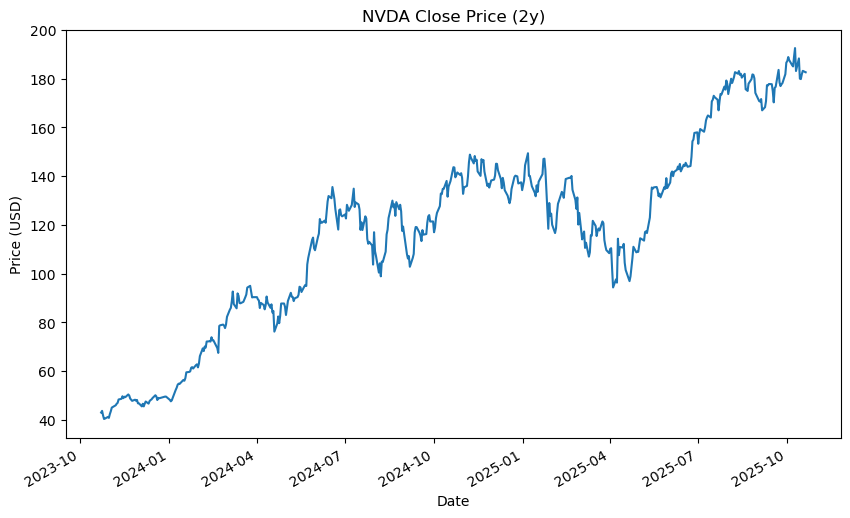

Saved nvda_snapshot.csv


In [9]:
# Price history plot
hist = ticker.history(period='2y', interval='1d')
if not hist.empty:
    ax = hist['Close'].plot(title=f'{TICKER} Close Price (2y)')
    ax.set_ylabel('Price (USD)')
    plt.show()
else:
    print('No historical data returned.')

# Save outputs
out = {
    'snapshot': pd.Series(metrics),
}

# Export snapshot
snap_df = pd.DataFrame.from_dict(out)
snap_df.to_csv('nvda_snapshot.csv')
print('Saved nvda_snapshot.csv')


---

## Decision checklist (automatable rules)

Use quantitative filters and qualitative checks to produce a recommendation. Example rule weights (customise):

- **Valuation (40%)**: Compare P/S, P/E to historical median and peer group. If P/S > 3x historical median and growth expectations not > 30% CAGR, mark as overvalued.
- **Growth (20%)**: Revenue & datacenter growth > 30% YoY -> positive.
- **Analyst sentiment (15%)**: >60% buy ratings -> positive.
- **Insider activity (10%)**: Net insider buying -> positive, heavy selling -> negative.
- **Institutional flows (10%)**: Net inflows last 12 months -> positive.
- **Macro & concentration risk (5%)**: Dependency on one segment or geopolitical constraints.

**Automated output:** The notebook computes each component score (0-100) and yields a weighted total and final label: Buy / Hold / Sell.

---


In [10]:
# Simple scoring template (fill with real computed numbers after runs)
# These are placeholders to show structure
valuation_score = 60  # 0-100
growth_score = 85
analyst_score = 75
insider_score = 40
institutional_score = 70
macro_score = 60

weights = {'valuation':0.4,'growth':0.2,'analyst':0.15,'insider':0.1,'institutional':0.1,'macro':0.05}

final_score = (valuation_score*weights['valuation'] + growth_score*weights['growth'] + analyst_score*weights['analyst'] + insider_score*weights['insider'] + institutional_score*weights['institutional'] + macro_score*weights['macro'])

print('Final composite score (0-100):', final_score)
if final_score >= 70:
    print('Recommendation: BUY')
elif final_score >= 50:
    print('Recommendation: HOLD')
else:
    print('Recommendation: SELL')


Final composite score (0-100): 66.25
Recommendation: HOLD
